# Web Assay Demo

This notebook walks through a general use case for the Web Assay.
This includes initalizing the web assay class with custom parsers, staining rendered pages to spot check, and creating a paintings which are visual references for how the images are stained.

This is the workflow we employ for our experiment:

<img src='../assets/assay-flow.png'>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import glob
import inspect
import random
sys.path.append('..')

from PIL import Image
import numpy as np

import utils.parsers as P
from utils.config import cat2color, window_size, user_agent
from utils.web_assay import GoogleWebAssay, paint_abstract_representation

In [3]:
# inputs
term = 'john-cho'
fn_input = f'../data/demo/{term}.html'

# outputs
fn_metadata = f'../data/demo/{term}-parsed.jsonl'
fn_screenshot = f'../data/demo/{term}-screenshot.png'
fn_abstract_painting = f'../data/demo/{term}-abstract.png'
fn_stained_screenshot = f'../data/demo/{term}-stained.png'

# determines whether or not you see the browser.
headless = True

In [4]:
# this imports each parser function into a list.
parser_functions = [
    o[1] for o in inspect.getmembers(P)
    if inspect.isfunction(o[1]) and
    '_parser' in o[0]
]
len(parser_functions)

68

In [5]:
# an example of a parser:
parser_functions[0]

<function utils.parsers.ads_aria_parser(body: bs4.element.Tag) -> List[Dict]>

## Initalizing and running Web Assay

In [6]:
assay = GoogleWebAssay(user_agent = user_agent,
                       window_size = window_size,
                       parser_functions = parser_functions,
                       color_palette = cat2color,
                       headless = headless)

In [7]:
# you can either visit pages in the browser manually, programmatically, or open saved HTML.
assay.open_local_html(fn_input)

You can use `assay.run` to parse the page. You can use the `stain` argument to color in elements.
This is useful for spot checking. Further you can inspect an element and see how it was labelled.

In [8]:
assay.run(stain=True)

`stain` can be set to specific categories (organic|link|ads|amp|answer)to selectively parse and stain just that category.

```
assay.run(stain='organic')
```

Beyond spot checking and development, `stain` should be set to `False` (which is a lot faster, since stain involves injecting custom style attributes in the HTML).

After running this function, the parsed metadata is stored in the 'element_metadata' attribute, which is a Pandas dataframe.

In [9]:
df = assay.element_metadata
df.head()

,text,link,domain,xpath,element_class,category,element,tag,attrs,dimensions,location,area,area_page,fn_input
0,AdAd·www.thegrudge.movie/The Grudge | Watch th...,None,google.com,/html/body/div[10]/div/div[6]/div/div[1]/div[2...,C4eCVc|c,ads-aria,"[[Ad], [[<div data-hveid=""CBIQAA""><div class=""...",div,"{'class': ['C4eCVc', 'c'], 'id': 'tads', 'aria...","{'height': 344.66668701171875, 'width': 347.0}","{'x': 8, 'y': 166}",119599.340393,119599.340393,None
1,John ChoHis life in images,https://www.google.com/search/static/gs/m03l3j...,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,KDlObe|amp_r,amp-visual_stories,"[[[<div class=""iJXt7e""><div class=""Gkvhhd""> <d...",a,"{'class': ['KDlObe', 'amp_r'], 'href': 'https:...","{'height': 72.0, 'width': 315.0}","{'x': 24, 'y': 1068}",0.000000,22680.000000,None
2,,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,swKmGc|y3tzvc|oRJe3d|r-iim9jiQmDSiU,link-button,"[ , [[<path d=""M12 4l-1.41 1.41L16.17 11H4v2h1...",a,"{'class': ['swKmGc', 'y3tzvc', 'oRJe3d', 'r-ii...","{'height': 52.0, 'width': 60.0}","{'x': 295, 'y': 1370}",0.000000,3120.000000,None
3,View all,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,oRJe3d|r-i6_uL7pDs5eA,link-button,"[ , [[<span class=""PUDfGe z1asCe lYxQe""><svg f...",a,"{'class': ['oRJe3d', 'r-i6_uL7pDs5eA'], 'role'...","{'height': 86.0, 'width': 58.0}","{'x': 876, 'y': 1540}",0.000000,0.000000,None
4,,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,swKmGc|y3tzvc|oRJe3d|r-iO5LDsioyRPE,link-button,"[ , [[<path d=""M12 4l-1.41 1.41L16.17 11H4v2h1...",a,"{'class': ['swKmGc', 'y3tzvc', 'oRJe3d', 'r-iO...","{'height': 52.0, 'width': 60.0}","{'x': 295, 'y': 1737}",0.000000,3120.000000,None


Dataframes like this are used for our analyses. Below is an example of how much area is covered by each element we parsed from this page:

In [10]:
( df.groupby(['category']).area_page.sum() / 
  df.area_page.sum() ).sort_values(ascending=False)

category
organic-search_result_1a           0.371256
link-google                        0.203603
amp-search_result_3                0.081848
ads-aria                           0.072334
answer-expand_2                    0.057677
link-youtube                       0.057463
link-img_reverse                   0.035969
amp-card                           0.026024
answer-knowledge_panel_answer_1    0.021396
answer-knowledge_graph_factoid     0.017901
organic                            0.016793
amp-visual_stories                 0.013717
link-knowledge_panel_tab           0.010538
answer-expand_3                    0.007345
link-button                        0.005661
link-load_more                     0.000474
Name: area_page, dtype: float64

## Selenium native functions
Web Assay is built with Selenium, you can call `assay.driver` to access the Selenium driver.

In [11]:
# refresh the page
assay.driver.refresh()
time.sleep(1)

# scroll down 2000 pixels
assay.driver.execute_script("window.scrollTo(0, 2000);")
time.sleep(3)

# return to the top of the page
assay.driver.execute_script("window.scrollTo(0, 0);")

# let's also save the metadata
assay.run(stain=False)
assay.element_metadata.to_json(fn_metadata,
                               orient='records',
                               lines=True)

We will use the Selenium driver to take a full-page screenshot, this is baked into Web Assay as a function.

In [12]:
assay.screenshot_full(fn_screenshot)

Let's take a peak at the screenshot:

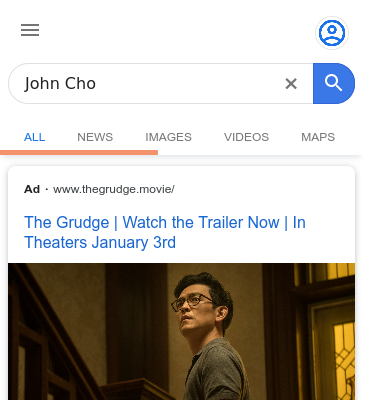

In [13]:
Image.open(fn_screenshot).crop([0 ,0, 375, 400])

## Creating visual artifacts
We can use the parsed metadata stored in `assay.element_metadata`, as well as the full screenshot to get an accurate portrayal of how Web Assay categorizes elements on the page.

To do with we use `paint_abstract_representation` to create paintings of the Web Assay's categorization. This function is just a wrapper around a p5 script. p5 is a drawing library, and not very function-friendly. That is why we've made a functional wrapper around a script.

This is more accurate than the staining from `assay.run()`, because it will stain images and get the correct shape of text spans.

In [14]:
# Painting shapes ontop of the screenshot. 
paint_abstract_representation(fn_metadata=fn_metadata,
                              fn_out=fn_stained_screenshot,
                              fn_img=fn_screenshot,
                              verbose=True)

python ../utils/draw_img.py --input ../data/demo/john-cho-parsed.jsonl --output ../data/demo/john-cho-stained.png --img ../data/demo/john-cho-screenshot.png --verbose 1


b'File ../data/demo/john-cho-stained.png exists.\n'

In [15]:
# Painting shapes on a white canvas
paint_abstract_representation(fn_metadata=fn_metadata,
                              fn_out=fn_abstract_painting,
                              verbose=True)

python ../utils/draw_img.py --input ../data/demo/john-cho-parsed.jsonl --output ../data/demo/john-cho-abstract.png --verbose 1


b'File ../data/demo/john-cho-abstract.png exists.\n'

# Let's preview what the paintings look like

We use the stained screenshots for spot checking (left) and the abstract paintings (right) for error analysis. Although we calculate area using the metadata in `assay.element_metadata`, we can count the pixels from the abstract also.

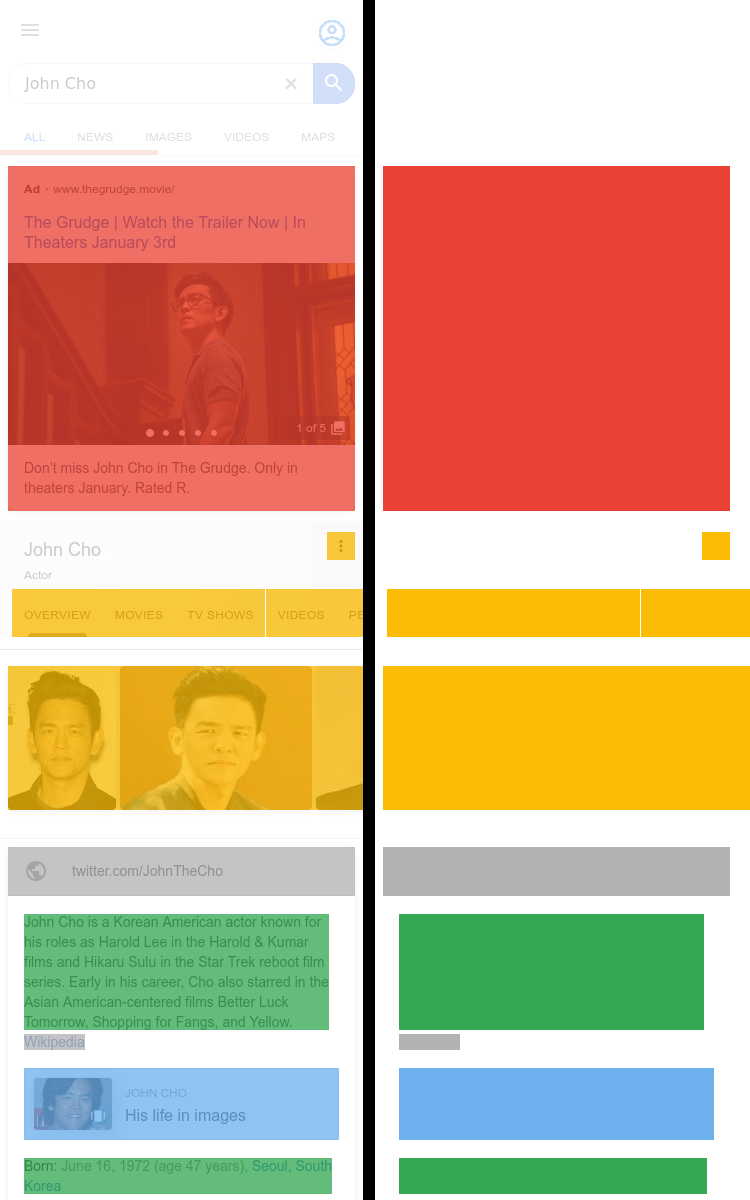

In [16]:
stained_screenshot = Image.open(fn_stained_screenshot).crop([0, 0, 375, 1200])
abstract_painting = Image.open(fn_abstract_painting).crop([0, 0, 375, 1200])

Image.fromarray(
    np.hstack((
        np.array(stained_screenshot), 
        np.array(abstract_painting)
    ))
)

In [17]:
# let's close the driver.
assay.close_driver()